In [3]:
import os
import sys
sys.path.insert(0, '/home/zzhuang/PseCo')
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image, to_tensor
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import tqdm
import albumentations as A
import torch.nn as nn
import torchvision
import torchvision.ops as vision_ops
from ops.foundation_models.segment_anything.utils.amg import batched_mask_to_box
from ops.ops import _nms, plot_results, convert_to_cuda
plt.rcParams["figure.dpi"] = 300
import json
torch.cuda.set_device(0)
torch.autograd.set_grad_enabled(False)
!gpustat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
121.pami.group            Mon Dec 11 17:09:25 2023  515.105.01
[0] NVIDIA A100-PCIE-40GB | 26°C,   0 % |  2114 / 40960 MB |
[1] NVIDIA A100-PCIE-40GB | 26°C,   0 % | 22819 / 40960 MB | yfyuan(10277M) zzhuang(1047M) yfyuan(10927M)
[2] NVIDIA A100-PCIE-40GB | 52°C, 100 % | 28118 / 40960 MB | zzhuang(3647M) zhengxin(23899M)
[3] NVIDIA A100-PCIE-40GB | 55°C,  97 % | 36138 / 40960 MB | zzhuang(9355M) zhengxin(26215M)


In [4]:
from ops.foundation_models.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, build_sam, build_sam_vit_b, build_sam_vit_h, build_sam_vit_l

# sam = build_sam_vit_b().cuda().eval()
# sam = build_sam_vit_l().cuda().eval()
sam = build_sam_vit_h().cuda().eval()

In [1]:
project_root = '/home/zzhuang/PseCo'

In [11]:
def read_image(fname):
    img = Image.open(f'{project_root}/data/fsc147/images_384_VarV2/{fname}')
    transform = A.Compose([
        A.LongestMaxSize(1024),
        A.PadIfNeeded(1024, border_mode=0, position=A.PadIfNeeded.PositionType.TOP_LEFT),
    ])
    img = Image.fromarray(transform(image=np.array(img))['image'])
    return img

In [26]:
all_data = json.load(open(f'{project_root}/data/fsc147/annotation_FSC147_384_with_gt.json'))
for fname in tqdm.tqdm(all_data):
    target = all_data[fname]
    scale = 1024 / max(target['width'], target['height'])
    target['annotations'] = {'points': torch.Tensor([target['annotations'][l]['points'] for l in target['annotations']]).float() * scale}
    target['box_examples_coordinates'] = torch.Tensor(target['box_examples_coordinates']).float() * scale

100%|████████████████████████████████████| 6054/6054 [00:00<00:00, 16852.50it/s]


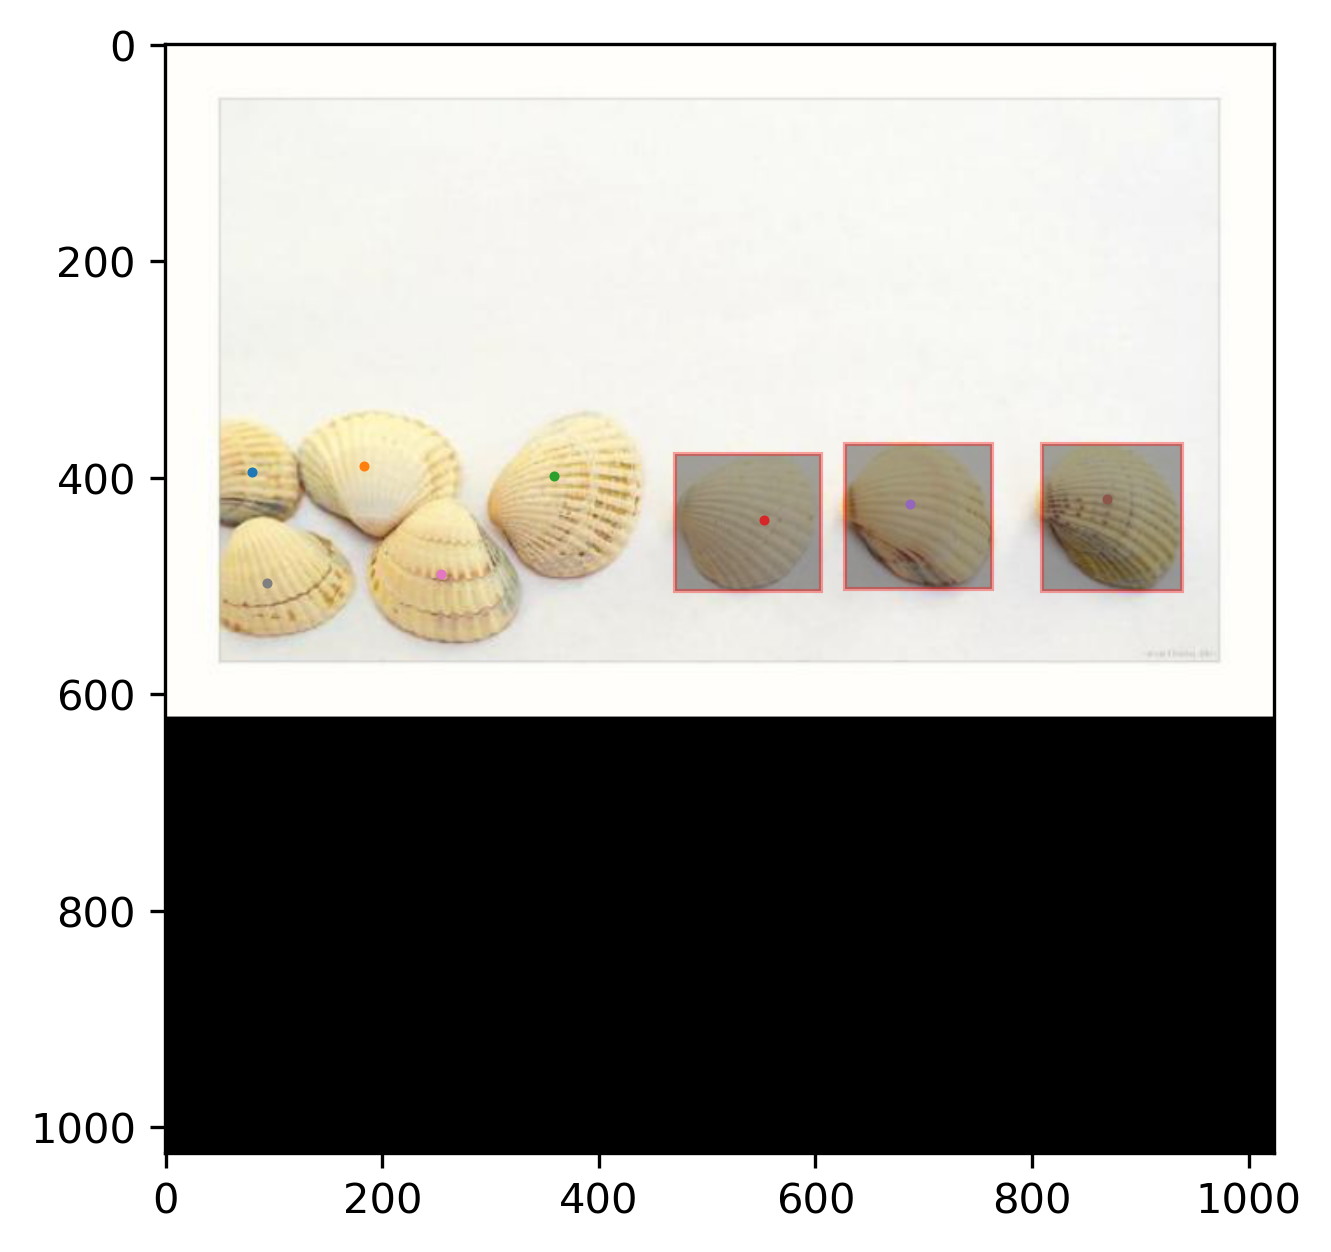

In [29]:
fname = '2.jpg'
plot_results(read_image(fname),
             points=all_data[fname]['annotations']['points'],
             bboxes=all_data[fname]['box_examples_coordinates']
             )

# Generate image features

In [13]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
for fname in tqdm.tqdm(all_data):
    image = read_image(fname)
    with torch.no_grad():
        new_image = transform(image).unsqueeze(0).cuda()
        features = sam.image_encoder(new_image)
    all_data[fname]['features'] = features.cpu()

In [14]:
os.makedirs(f'{project_root}/data/fsc147/sam/', exist_ok=True)

In [38]:
# torch.save(all_data, f'{project_root}/data/fsc147/sam/all_data_vitl.pth')
# torch.save(all_data, f'{project_root}/data/fsc147/sam/all_data_vith.pth')
all_data = torch.load(f'{project_root}/data/fsc147/sam/all_data_vith.pth', map_location='cpu')

# Segment Everything with a grid of point prompts 

In [46]:
from ops.foundation_models.segment_anything.utils.amg import build_point_grid, calculate_stability_score

# points_per_side = 64
points_per_side = 32
# points_per_side = 16
grid_points = build_point_grid(points_per_side)

segment_anything_data = {}
for fname in tqdm.tqdm(all_data):
    # features = torch.load('/home/zzhuang/DATASET2/COCO/sam_vith/Org_features/' + fname, map_location='cpu').cuda()
    features = all_data[fname]['features'].cuda()
    h, w = all_data[fname]['height'], all_data[fname]['width']
    grid_points_ = grid_points.copy()
    grid_points_[:, 0] = grid_points_[:, 0] * w
    grid_points_[:, 1] = grid_points_[:, 1] * h
    scale = 1024 / max(h, w)
    grid_points_ = grid_points_ * scale
    points = all_data[fname]['annotations']['points'].cpu().numpy()
    points = np.concatenate([grid_points_, points],axis=0)
    points = torch.from_numpy(points).cuda()

    outputs = {}
    for indices in torch.arange(len(points)).split(512):
        with torch.no_grad():
            outputs_ = sam.forward_sam_with_embeddings(features, points[indices])
            
        for k in outputs_:
            if k not in outputs:
                outputs[k] = outputs_[k]
            else:
                outputs[k] = torch.cat([outputs[k], outputs_[k]], dim=0)

    pred_masks = outputs['pred_logits'].view(-1, 256, 256)
    stability_scores = calculate_stability_score(pred_masks, 0, 1.)
    pred_ious = outputs['pred_ious'].view(-1)
    pred_boxes = outputs['pred_boxes'].view(-1, 4)
    pred_masks = (pred_masks > 0.)
    indices = vision_ops.nms(pred_boxes, pred_ious, 0.7)
    mask = torch.zeros(len(pred_ious)).bool().cuda()
    mask[indices] = True
    mask = mask & (stability_scores > 0.95)
    mask = mask & (pred_ious > 0.88)
    bboxes = pred_boxes * max(h, w) / 1024
    bboxes[:, [0, 2]] = bboxes[:, [0, 2]].clamp(0, w)
    bboxes[:, [1, 3]] = bboxes[:, [1, 3]].clamp(0, h)
    box_areas = vision_ops.box_area(bboxes)
    mask = mask & ((box_areas < (h * w * 0.75)) & (box_areas > 50.))
    mask = mask & (((bboxes[:, 3] - bboxes[:, 1]) > 1.) & ((bboxes[:, 2] - bboxes[:, 0]) > 1.))
    
    pred_masks = pred_masks[mask]
    pred_boxes = pred_boxes[mask]
    pred_ious = pred_ious[mask]
    
    contour_center_points = []
    mask = torch.ones(len(pred_masks)).bool()
    for i in range(len(pred_masks)):
        m = pred_masks[i].cpu().numpy().astype(np.uint8)
        from ops.foundation_models.segment_anything.utils.amg import remove_small_regions
        # mask = remove_small_regions(mask)
        min_area = 10
        m, changed = remove_small_regions(m, min_area, mode="holes")
        unchanged = not changed
        m, changed = remove_small_regions(m, min_area, mode="islands")
        unchanged = unchanged and not changed
        m = m.astype(np.uint8)

        import imutils, cv2

        cnts = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        if len(cnts) == 0:
            mask[i] = False
            continue
        else:
            cnts = cnts[0] * 4
            M = cv2.moments(cnts)
            if M['m01'] <= 0.0001:
                mask[i] = False
                continue
            cX = int(M["m10"] / (M["m00"] + 0.0001))
            cY = int(M["m01"] / (M["m00"] + 0.0001))
            contour_center_points.append([cX, cY])
    contour_center_points = torch.Tensor(contour_center_points)
    pred_boxes = pred_boxes[mask]
    pred_ious = pred_ious[mask]
    segment_anything_data[fname] = {
        'pred_boxes': pred_boxes.cpu(),
        'pred_points': contour_center_points.cpu(),
        'pred_ious': pred_ious.cpu(),
    }
    # print(fname)
    # if fname == '6.jpg':
    #     break
    # break

In [47]:
# torch.save(segment_anything_data, f'{project_root}/data/fsc147/sam/segment_anything_data_vith.pth')

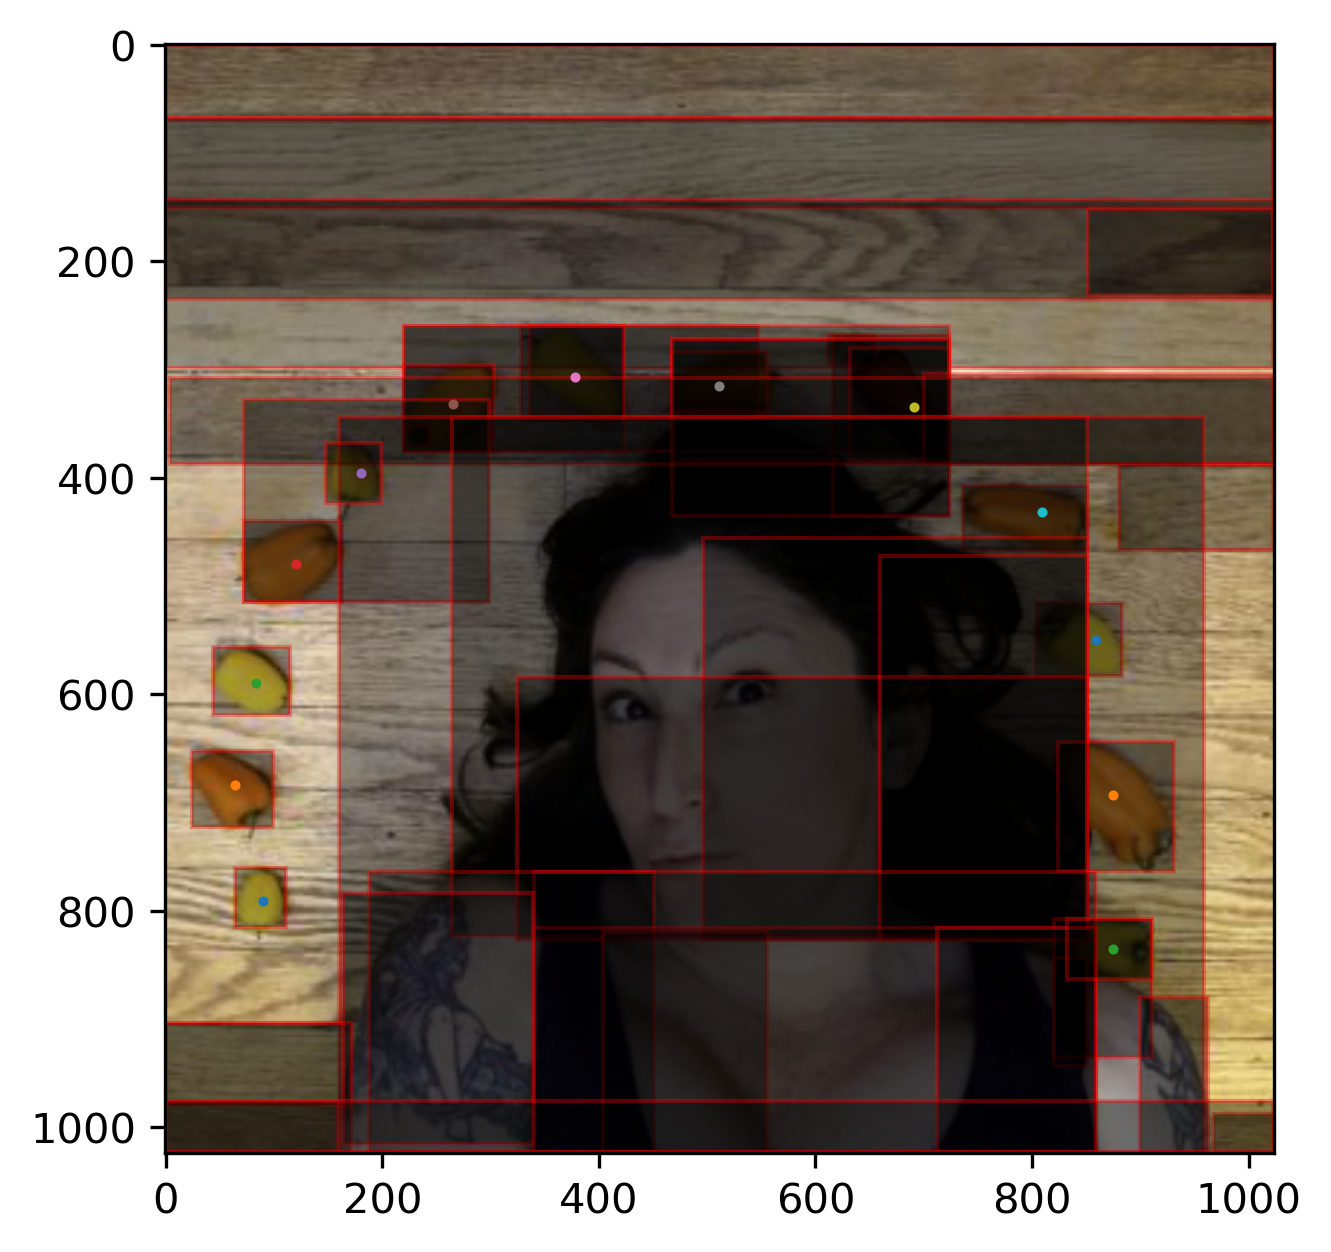

In [45]:
# read_image(fname)
fname = list(segment_anything_data)[0]
# fname = '2.jpg'
plot_results(read_image(fname),
             points=all_data[fname]['annotations']['points'],
             bboxes=segment_anything_data[fname]['pred_boxes'],
             )

In [9]:
# torch.save(all_data, f'{project_root}/data/fsc147/sam/all_data_vitl.pth')
# torch.save(all_data, f'{project_root}/data/fsc147/sam/all_data_vitr.pth')

# Generate pseudo labels with ground-truth point prompts 

In [55]:
pseudo_boxes_data = {}
for fname in tqdm.tqdm(all_data):
    features = all_data[fname]['features'].cuda()
    points = all_data[fname]['annotations']['points'].cuda()

    outputs = {}
    for indices in torch.arange(len(points)).split(512):
        with torch.no_grad():
            outputs_ = sam.forward_sam_with_embeddings(features, points[indices])
            
        for k in outputs_:
            if k not in outputs:
                outputs[k] = outputs_[k]
            else:
                outputs[k] = torch.cat([outputs[k], outputs_[k]], dim=0)

    pred_masks = outputs['pred_logits'][torch.arange(len(points)), torch.argmax(outputs['pred_ious'], dim=1)]
    pred_masks = (pred_masks > 0.)
    for i in range(len(pred_masks)):
        m = pred_masks[i].cpu().numpy().astype(np.uint8)
        from ops.foundation_models.segment_anything.utils.amg import remove_small_regions
        min_area = 10
        m, changed = remove_small_regions(m, min_area, mode="holes")
        unchanged = not changed
        m, changed = remove_small_regions(m, min_area, mode="islands")
        unchanged = unchanged and not changed
        m = m.astype(np.uint8)
        pred_masks[i] = torch.from_numpy(m).bool()
    pred_boxes = batched_mask_to_box(F.interpolate(pred_masks.unsqueeze(1).float(), size=(1024, 1024)).squeeze(1).bool())
    pseudo_boxes_data[fname] = pred_boxes.cpu()

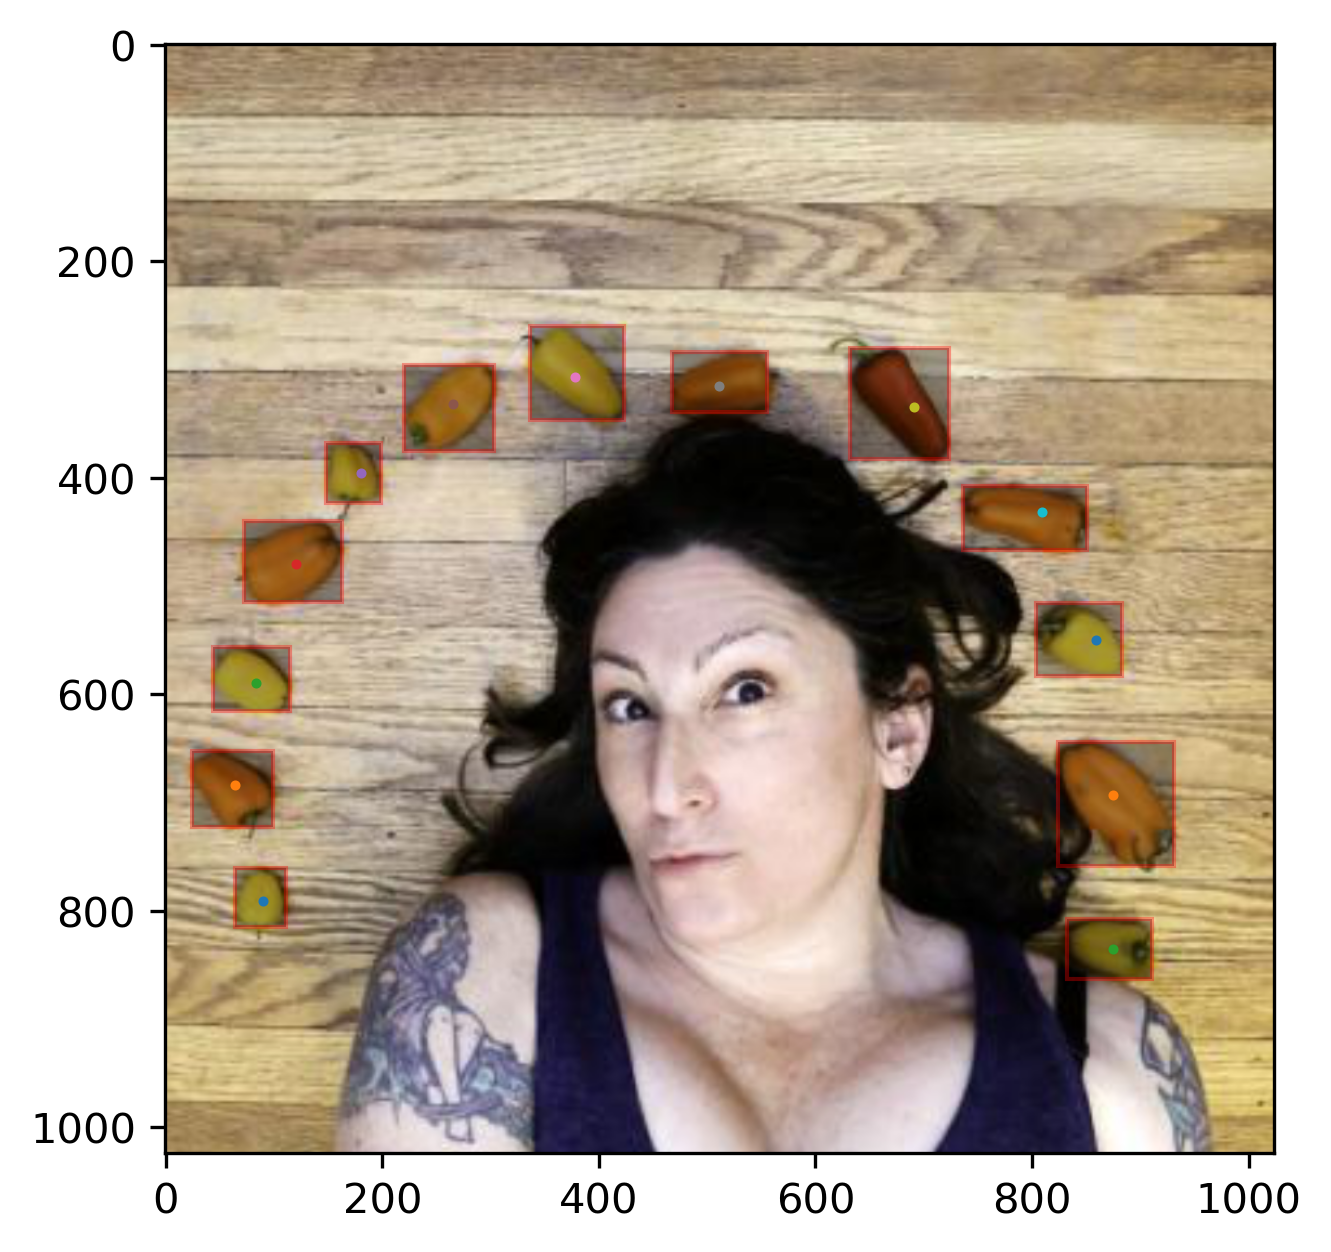

In [54]:
# read_image(fname)
fname = list(pseudo_boxes_data)[0]
# fname = '2.jpg'
plot_results(read_image(fname),
             points=all_data[fname]['annotations']['points'],
             bboxes=pseudo_boxes_data[fname],
             )

In [56]:
# torch.save(pseudo_boxes_data, f'{project_root}/data/fsc147/sam/pseudo_boxes_data_vith.pth')

# Generate text and example CLIP embeddings

In [58]:
from ops.foundation_models import clip

clip.available_models()

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
import torchvision

normalize = torchvision.transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                                             std=(0.26862954, 0.26130258, 0.27577711))

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [61]:
def extract_clip_features(fname, bboxes):
    image = read_image(fname)
    examples = []
    for box in bboxes:
        example = image.crop(box.long().tolist())
        example = example.resize((224, 224))
        example = normalize(to_tensor(example)).unsqueeze(0)
        examples.append(example)
    examples = torch.cat(examples)
    e = []
    with torch.no_grad():
        for indices in torch.arange(len(examples)).split(256):
            e.append(model.encode_image(examples[indices].cuda()).float())
    e = torch.cat(e, dim=0)
    e = F.normalize(e, dim=1).cpu()
    return e

In [66]:
# Image Embeddings
for fname in tqdm.tqdm(all_data):
    boxes = all_data[fname]['box_examples_coordinates']
    all_data[fname]['example_clip_features'] = extract_clip_features(fname, boxes.reshape(-1, 4)).view(-1, boxes.size(0), 512)

In [ ]:
#@title Define hyperparameters
FLAGS = {
    'prompt_engineering': True,
    'this_is': True,
    
    'temperature': 100.0,
    'use_softmax': False,
}
from easydict import EasyDict
FLAGS = EasyDict(FLAGS)
def article(name):
  return 'an' if name[0] in 'aeiou' else 'a'

def processed_name(name, rm_dot=False):
  # _ for lvis
  # / for obj365
  res = name.replace('_', ' ').replace('/', ' or ').lower()
  if rm_dot:
    res = res.rstrip('.')
  return res

single_template = [
    'a photo of {article} {}.'
]

multiple_templates = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',


    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]
def build_text_embedding(categories):
    if FLAGS.prompt_engineering:
        templates = multiple_templates
    else:
        templates = single_template

    with torch.no_grad():
        all_text_embeddings = {}
        print('Building text embeddings...')
        for category in tqdm.tqdm(categories):
            texts = [
                template.format(processed_name(category, rm_dot=True),
                                article=article(category))
                for template in templates]
            if FLAGS.this_is:
                texts = [
                    'This is ' + text if text.startswith('a') or text.startswith('the') else text
                    for text in texts
                ]
            texts = clip.tokenize(texts)  #tokenize
            texts = texts.cuda()
            text_embeddings = model.encode_text(texts)  #embed with text encoder
            text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
            text_embedding = text_embeddings.mean(dim=0)
            text_embedding /= text_embedding.norm()
            all_text_embeddings[category] = text_embedding.float().cpu()

    return all_text_embeddings
# text CLIP embeddings
classes = set(all_data[fname]['class_name'] for fname in all_data)
imagenet_classes = classes
print(imagenet_classes)
print(len(imagenet_classes))
zeroshot_weights = build_text_embedding(imagenet_classes)
zeroshot_weights

In [ ]:
# torch.save(zeroshot_weights, f'{project_root}/data/fsc147/clip_text_prompt.pth')